In [1]:
import glob
import sys
import os
sys.path.append(os.path.abspath("3DCNN")) # add preprocessing methods
sys.path.append(os.path.abspath("GNN")) # add preprocessing methods
from FilterAtoms3DCNN import create_grids
from FilterAtomsGraphs import create_graphs

protein_file = "/home/aashish/cholestrol/pz2_cholesterol/15_box/test_run/anton_last_protein.pdb"
unlabeled_files = glob.glob("/home/aashish/cholestrol/pz2_cholesterol/15_box/test_run/6.sdf_2_pdb/*.pdb")

dataset_name = "sdf_2"

create_grids(protein_file, unlabeled_files, dataset_name) # creates 3d cnn files

/home/alexhernandez/miniconda3/envs/bio-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total atoms within 5.0 Å cutoff: 36
Total atoms within 5.0 Å cutoff: 41
Total atoms within 5.0 Å cutoff: 63
Total atoms within 5.0 Å cutoff: 46
Total atoms within 5.0 Å cutoff: 45
Total atoms within 5.0 Å cutoff: 68
Total atoms within 5.0 Å cutoff: 63
Total atoms within 5.0 Å cutoff: 54
Total atoms within 5.0 Å cutoff: 60
Total atoms within 5.0 Å cutoff: 57
Total atoms within 5.0 Å cutoff: 35
Total atoms within 5.0 Å cutoff: 38
Total atoms within 5.0 Å cutoff: 24
Total atoms within 5.0 Å cutoff: 30
Total atoms within 5.0 Å cutoff: 44
Total atoms within 5.0 Å cutoff: 79
Total atoms within 5.0 Å cutoff: 75
Total atoms within 5.0 Å cutoff: 72
Total atoms within 5.0 Å cutoff: 75
Total atoms within 5.0 Å cutoff: 73
Total atoms within 5.0 Å cutoff: 51
Total atoms within 5.0 Å cutoff: 80
Total atoms within 5.0 Å cutoff: 65
Total atoms within 5.0 Å cutoff: 78
Total atoms within 5.0 Å cutoff: 67
Total atoms within 5.0 Å cutoff: 51
Total atoms within 5.0 Å cutoff: 61
Total atoms within 5.0 Å cut

In [2]:
unlabeled_filtered = glob.glob(f"filtered-{dataset_name}-piezo-pdbs/unlabeled/*.pdb") # creates gat, gcn, and gnn files
create_graphs(unlabeled_filtered, dataset_name)

['filtered-sdf_2-piezo-pdbs/unlabeled/box262.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box263.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box277.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box278.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box279.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box292.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box293.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box294.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box307.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box308.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box309.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box606.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box607.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box608.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box619.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/box620.-filtered.pdb', 'filtered-sdf_2-piezo-pdbs/unlabeled/bo

In [3]:
import torch
import torch.nn as nn
import glob
import csv
import numpy as np
import os

# 3D CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv0 = nn.Conv3d(in_channels=37, out_channels=64, kernel_size=1, stride=1, padding=0) # play around with output channels
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        #self.dropout_conv = nn.Dropout3d(p=0.05)
        
        # After two pooling layers, spatial dimensions reduce from 40x40x40 -> 5x5x5
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 256)  # Try increasing over 256
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 1 output for docking status/position

        #self.dropout_fc = nn.Dropout(p=0.15)
        
    def forward(self, x):
        # Forward pass through Conv layers
        x = self.pool(torch.relu(self.conv0(x)))  # Conv0 -> ReLU -> Pooling
        #x = self.dropout_conv(x)
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 3 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x)) #use tanh activation
        #x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)  # Final layer (output layer)
        #x = torch.clamp(x, min=1e-7, max=1 - 1e-7)  # Clamp outputs to avoid extreme values
        
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_exp1 = []
models_exp2 = []
models_exp3 = []
models_exp4 = []
models_exp5 = []

k = 50

for i in range (1, (k + 1)):
    model_exp1 = CNN3D().to(device)

    model_exp2 = CNN3D().to(device)

    model_exp3 = CNN3D().to(device)

    model_exp4 = CNN3D().to(device)

    model_exp5 = CNN3D().to(device)

    model_path = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp1/Models/model_bin_{i}.pth" 
    model_exp1.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp2/Models/model_bin_{i}.pth" 
    model_exp2.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp3/Models/model_bin_{i}.pth" 
    model_exp3.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp4/Models/model_bin_{i}.pth" 
    model_exp4.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp5/Models/model_bin_{i}.pth" 
    model_exp5.load_state_dict(torch.load(model_path, map_location=device))

    model_exp1.eval()
    model_exp2.eval()
    model_exp3.eval()
    model_exp4.eval()
    model_exp5.eval()

    models_exp1.append(model_exp1)
    models_exp2.append(model_exp2)
    models_exp3.append(model_exp3)
    models_exp4.append(model_exp4)
    models_exp5.append(model_exp5)

def evaluate_file(model, file_path, threshold=0.5):
    grid = np.load(file_path)

    non_padded_rows = np.sum(np.any(grid != 0, axis=(3)))
    
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)
    grid_tensor = grid_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(grid_tensor)

    prob = output[0, 1].item()

    predicted_class = int(prob >= threshold)

    return predicted_class, prob, non_padded_rows

def evaluate_directory(dir, csv_output, models):
    predictions = []
    capture_rate = 0
    overlapping_capture_rate = 0
    overlapping_index = 0

    files = glob.glob(f"{dir}/*.npy")

    model_positive_counts = [0] * len(models)
    model_negative_counts = [0] * len(models)

    #print(f"{'Filename':<120} {'IndividualCaptureRate':<25} NumberOfAtoms")

    os.makedirs(os.path.dirname(csv_output), exist_ok=True)

    with open(csv_output, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "average_score", "score_std", "number_atoms"]) 

        for file in sorted(files):    
            model_probs = []
            for model_index, model in enumerate(models):
                predicted_class, prob, non_padded_rows = evaluate_file(model, file)
                model_probs.append(prob)

                if predicted_class == 1:
                    model_positive_counts[model_index] += 1
                else:
                    model_negative_counts[model_index] += 1

            prediction_mean = np.mean(model_probs)
            prediction_std = np.std(model_probs)

            capture_rate += prediction_mean
            #if non_padded_rows <= 65 and non_padded_rows >= 55:
            #print(f"{file:<120} {prediction:<25} {non_padded_rows}")
            overlapping_capture_rate += prediction_mean
            overlapping_index += 1
            writer.writerow([file, prediction_mean, prediction_std, non_padded_rows])

    capture_rate /= len(files)
    overlapping_capture_rate /= overlapping_index

    print("\nModel Predictions Summary:")
    for i, (pos, neg) in enumerate(zip(model_positive_counts, model_negative_counts), start=1):
        print(f"Model {i}: Positives = {pos}, Negatives = {neg}")

    print("Overlapping Capture Rate is", overlapping_capture_rate)

    return capture_rate

import pandas as pd

def get_spy_info(csv):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    # Extract the 'average_score' column
    scores = df["average_score"]

    # Compute statistics
    mean_score = scores.mean()
    percentile_50 = scores.quantile(0.5)
    percentile_25 = scores.quantile(0.25)
    percentile_75 = scores.quantile(0.75)
    min_score = scores.min()
    max_score = scores.max()

    # Print results
    print(f"Mean: {mean_score:.6f}")
    print(f"50th Percentile (Median): {percentile_50:.6f}")
    print(f"Bottom 25 Percentile: {percentile_25:.6f}")
    print(f"Top 25 Percentile: {percentile_75:.6f}")
    print(f"Min: {min_score:.6f}")
    print(f"Max: {max_score:.6f}\n")

    return mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score

csv_output_exp1 = "../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp1/NewResults/SpyCaptureRates.csv"
csv_output_exp2 = "../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp2/NewResults/SpyCaptureRates.csv"
csv_output_exp3 = "../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp3/NewResults/SpyCaptureRates.csv"
csv_output_exp4 = "../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp4/NewResults/SpyCaptureRates.csv"
csv_output_exp5 = "../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp5/NewResults/SpyCaptureRates.csv"

print("Experiment 1 Spy Results:")
mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1 = get_spy_info(csv_output_exp1)

print("Experiment 2 Spy Results:")
mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2 = get_spy_info(csv_output_exp2)

print("Experiment 3 Spy Results:")
mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3 = get_spy_info(csv_output_exp3)

print("Experiment 4 Spy Results:")
mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4 = get_spy_info(csv_output_exp4)

print("Experiment 5 Spy Results:")
mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5 = get_spy_info(csv_output_exp5)

test_piezo_exp1 = f"{dataset_name}-piezo-grids/unlabeled"  
csv_output_exp1 = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp1/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_piezo_exp1, csv_output_exp1, models_exp1)

test_piezo_exp2 = f"{dataset_name}-piezo-grids/unlabeled"  
csv_output_exp2 = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_piezo_exp2, csv_output_exp2, models_exp2)

test_piezo_exp3 = f"{dataset_name}-piezo-grids/unlabeled"  
csv_output_exp3 = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp3/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_piezo_exp3, csv_output_exp3, models_exp3)

test_piezo_exp4 = f"{dataset_name}-piezo-grids/unlabeled"  
csv_output_exp4 = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp4/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_piezo_exp4, csv_output_exp4, models_exp4)

test_piezo_exp5 = f"{dataset_name}-piezo-grids/unlabeled"  
csv_output_exp5 = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp5/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_piezo_exp5, csv_output_exp5, models_exp5)

import pandas as pd

def apply_labeling_from_spies(csv, mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    # Extract protein ID from filename
    df['protein_id'] = df['filename']
    print(len(df['protein_id']), "is length of protein id's")

    # Group by protein for mean and max versions
    df1_grouped_mean = df.groupby('protein_id').agg({
        'average_score': 'mean',
        'number_atoms': 'first'
    }).reset_index()

    def get_min_max_label(score):
        if score < min_score:
            return "StrongNegative"
        elif min_score <= score < mean_score:
            return "PseudoNegative"
        elif mean_score <= score < max_score:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df1_grouped_mean["min_max_label"] = df1_grouped_mean["average_score"].apply(get_min_max_label)

    def get_percentile_label(score):
        if score < percentile_25:
            return "StrongNegative"
        elif percentile_25 <= score < percentile_50:
            return "PseudoNegative"
        elif percentile_50 <= score < percentile_75:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df1_grouped_mean["percentile_label"] = df1_grouped_mean["average_score"].apply(get_percentile_label)
    df1_grouped_mean["threshold_label"] = df1_grouped_mean["average_score"].apply(lambda x: "Negative" if x < 0.5 else "Positive")

    min_max_results = []
    min_max_results.append((df1_grouped_mean["average_score"] < min_score).sum()) # min_max_strong_negative_count
    min_max_results.append(((df1_grouped_mean["average_score"] > min_score) & (df1_grouped_mean["average_score"] < mean_score)).sum()) # min_max_pseudo_negative_count
    min_max_results.append(((df1_grouped_mean["average_score"] > mean_score) & (df1_grouped_mean["average_score"] < max_score)).sum()) # min_max_pseudo_positive_count
    min_max_results.append((df1_grouped_mean["average_score"] > max_score).sum()) # min_max_strong_positive_count

    percentile_results = []
    percentile_results.append((df1_grouped_mean["average_score"] < percentile_25).sum()) # percentile_strong_negative_count
    percentile_results.append(((df1_grouped_mean["average_score"] > percentile_25) & (df1_grouped_mean["average_score"] < percentile_50)).sum()) # percentile_pseudo_negative_count
    percentile_results.append(((df1_grouped_mean["average_score"] > percentile_50) & (df1_grouped_mean["average_score"] < percentile_75)).sum()) # percentile_pseudo_positive_count
    percentile_results.append((df1_grouped_mean["average_score"] > percentile_75).sum()) # percentile_strong_positive_count

    threshold_results = []
    threshold_results.append((df1_grouped_mean["average_score"] < 0.5).sum()) # threshold_negative_count
    threshold_results.append((df1_grouped_mean["average_score"] > 0.5).sum()) # threshold_positive_count

    # Table 1: Min/Max and Percentile
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    minmax_percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Min_Max (Using Mean)": min_max_results,
        "Percentile (75-50-25)": percentile_results
    })

    # Table 2: Threshold 0.5
    labels_2 = ["Negative", "Positive"]
    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold (0.5)": threshold_results
    })

    print(minmax_percentile_df,"\n", threshold_df)

    output_csv = csv.replace(".csv", "_labeled.csv")
    df1_grouped_mean.to_csv(output_csv, index=False)
    print(f"Updated CSV written to: {output_csv}")

    return min_max_results, percentile_results, threshold_results

def show_evaluation_results(min_max_all, percentile_all, threshold_all):
    # Compute mean and std for each label
    min_max_mean = np.mean(min_max_all, axis=0)
    min_max_std = np.std(min_max_all, axis=0)

    percentile_mean = np.mean(percentile_all, axis=0)
    percentile_std = np.std(percentile_all, axis=0)

    threshold_mean = np.mean(threshold_all, axis=0)
    threshold_std = np.std(threshold_all, axis=0)

    # Create DataFrames to display
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    labels_2 = ["Negative", "Positive"]

    min_max_df = pd.DataFrame({
        "Label": labels_4,
        "Min-Max Mean": min_max_mean,
        "Min-Max Std": min_max_std
    })

    percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Percentile Mean": percentile_mean,
        "Percentile Std": percentile_std
    })

    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold Mean": threshold_mean,
        "Threshold Std": threshold_std
    })

    # Display
    print("=== Min-Max Results ===")
    print(min_max_df)
    print("\n=== Percentile Results ===")
    print(percentile_df)
    print("\n=== Threshold Results ===")
    print(threshold_df)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)

min_max_results_exp1, percentile_results_exp1, threshold_results_exp1 = apply_labeling_from_spies(csv_output_exp1, mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1)
min_max_results_exp2, percentile_results_exp2, threshold_results_exp2 = apply_labeling_from_spies(csv_output_exp2, mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2)
min_max_results_exp3, percentile_results_exp3, threshold_results_exp3 = apply_labeling_from_spies(csv_output_exp3, mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3)
min_max_results_exp4, percentile_results_exp4, threshold_results_exp4 = apply_labeling_from_spies(csv_output_exp4, mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4)
min_max_results_exp5, percentile_results_exp5, threshold_results_exp5 = apply_labeling_from_spies(csv_output_exp5, mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5)

min_max_all = np.array([
    min_max_results_exp1,
    min_max_results_exp2,
    min_max_results_exp3,
    min_max_results_exp4,
    min_max_results_exp5
])

percentile_all = np.array([
    percentile_results_exp1,
    percentile_results_exp2,
    percentile_results_exp3,
    percentile_results_exp4,
    percentile_results_exp5
])

threshold_all = np.array([
    threshold_results_exp1,
    threshold_results_exp2,
    threshold_results_exp3,
    threshold_results_exp4,
    threshold_results_exp5
])

show_evaluation_results(min_max_all, percentile_all, threshold_all)

Experiment 1 Spy Results:
Mean: 0.909196
50th Percentile (Median): 0.998402
Bottom 25 Percentile: 0.971694
Top 25 Percentile: 0.999265
Min: 0.000393
Max: 0.999589

Experiment 2 Spy Results:
Mean: 0.911292
50th Percentile (Median): 0.997469
Bottom 25 Percentile: 0.947971
Top 25 Percentile: 0.999269
Min: 0.014354
Max: 0.999578

Experiment 3 Spy Results:
Mean: 0.928312
50th Percentile (Median): 0.998486
Bottom 25 Percentile: 0.983632
Top 25 Percentile: 0.999377
Min: 0.001310
Max: 0.999662

Experiment 4 Spy Results:
Mean: 0.894196
50th Percentile (Median): 0.997700
Bottom 25 Percentile: 0.958346
Top 25 Percentile: 0.999255
Min: 0.000063
Max: 0.999621

Experiment 5 Spy Results:
Mean: 0.922306
50th Percentile (Median): 0.997718
Bottom 25 Percentile: 0.982572
Top 25 Percentile: 0.998905
Min: 0.000010
Max: 0.999436


Model Predictions Summary:
Model 1: Positives = 518, Negatives = 1163
Model 2: Positives = 504, Negatives = 1177
Model 3: Positives = 482, Negatives = 1199
Model 4: Positives = 49

In [4]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.data import Data
import glob
import os
import csv
from torch_geometric.nn import GATConv, global_mean_pool

# Define GAT model for batched data
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.1):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=1, concat=True, edge_dim=1)
        self.pool = global_mean_pool  # Can also use global_max_pool or global_add_pool
        self.dropout = nn.Dropout(p=dropout_p)
        self.norm = nn.BatchNorm1d(out_channels)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        out, attn_weights = self.gat(x, edge_index, edge_attr, return_attention_weights=True)
        out = self.dropout(out)
        out = self.pool(out, batch)  # Pool over nodes in each graph
        out = self.norm(out)
        out = self.dropout(out) 
        out = self.linear(out)
        return out, attn_weights

def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_exp1 = []
models_exp2 = []
models_exp3 = []
models_exp4 = []
models_exp5 = []

k = 50

for i in range (1, (k + 1)):
    model_exp1 = GAT(in_channels=37, out_channels=32).to(device)

    model_exp2 = GAT(in_channels=37, out_channels=32).to(device)

    model_exp3 = GAT(in_channels=37, out_channels=32).to(device)

    model_exp4 = GAT(in_channels=37, out_channels=32).to(device)

    model_exp5 = GAT(in_channels=37, out_channels=32).to(device)

    model_path = f"../../Models/Cholesterol/GAT/GATModels-5A_exp1v2/Models/model_bin_{i}.pth" 
    model_exp1.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GAT/GATModels-5A_exp2v2/Models/model_bin_{i}.pth" 
    model_exp2.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GAT/GATModels-5A_exp3v2/Models/model_bin_{i}.pth" 
    model_exp3.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GAT/GATModels-5A_exp4v2/Models/model_bin_{i}.pth" 
    model_exp4.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GAT/GATModels-5A_exp5v2/Models/model_bin_{i}.pth" 
    model_exp5.load_state_dict(torch.load(model_path, map_location=device))

    model_exp1.eval()
    model_exp2.eval()
    model_exp3.eval()
    model_exp4.eval()
    model_exp5.eval()

    models_exp1.append(model_exp1)
    models_exp2.append(model_exp2)
    models_exp3.append(model_exp3)
    models_exp4.append(model_exp4)
    models_exp5.append(model_exp5)

def get_capture_rate(dir, csv_output, models):
    predictions = []
    capture_rate = 0
    overlapping_capture_rate = 0
    overlapping_index = 0

    files = glob.glob(f"{dir}/*.npy")

    model_Piezo_counts = [0] * len(models)
    model_negative_counts = [0] * len(models)

    os.makedirs(os.path.dirname(csv_output), exist_ok=True)

    with open(csv_output, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "average_score", "score_std", "number_atoms"]) 

        for file in sorted(files):    
            model_probs = []
            for model_index, model in enumerate(models):
                graph = organize_graph_and_add_weight(file, label=0).to(device)
                non_padded_rows = graph.x.size(0)
                with torch.no_grad():
                    out, _ = model(graph.x, graph.edge_index, graph.edge_attr, batch=torch.zeros(graph.x.size(0), dtype=torch.long).to(device))
                    prob = torch.sigmoid(out).item()
                    model_probs.append(prob)

                    if prob >= 0.5:
                        model_Piezo_counts[model_index] += 1
                    else:
                        model_negative_counts[model_index] += 1

            prediction_mean = np.mean(model_probs)
            prediction_std = np.std(model_probs)

            predictions.append((file, prediction_mean))
            capture_rate += prediction_mean
            #print(f"{file:<120} {prediction:<25} {non_padded_rows}")
            overlapping_capture_rate += prediction_mean
            overlapping_index += 1
            writer.writerow([file, prediction_mean, prediction_std, non_padded_rows])

    capture_rate /= len(files)
    overlapping_capture_rate /= overlapping_index

    print("\nModel Predictions Summary:")
    for i, (pos, neg) in enumerate(zip(model_Piezo_counts, model_negative_counts), start=1):
        print(f"Model {i}: piezo = {pos}, Negatives = {neg}")

    #print("Overlapping Capture Rate is", overlapping_capture_rate)

    return capture_rate

csv_output_exp1 = "../../Models/Cholesterol/GAT/GATModels-5A_exp1v2/NewResults/SpyCaptureRates.csv"
csv_output_exp2 = "../../Models/Cholesterol/GAT/GATModels-5A_exp2v2/NewResults/SpyCaptureRates.csv"
csv_output_exp3 = "../../Models/Cholesterol/GAT/GATModels-5A_exp3v2/NewResults/SpyCaptureRates.csv"
csv_output_exp4 = "../../Models/Cholesterol/GAT/GATModels-5A_exp4v2/NewResults/SpyCaptureRates.csv"
csv_output_exp5 = "../../Models/Cholesterol/GAT/GATModels-5A_exp5v2/NewResults/SpyCaptureRates.csv"

import pandas as pd

def get_spy_info(csv):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    # Extract the 'average_score' column
    scores = df["average_score"]

    # Compute statistics
    mean_score = scores.mean()
    percentile_50 = scores.quantile(0.5)
    percentile_25 = scores.quantile(0.25)
    percentile_75 = scores.quantile(0.75)
    min_score = scores.min()
    max_score = scores.max()

    # Print results
    print(f"Mean: {mean_score:.6f}")
    print(f"50th Percentile (Median): {percentile_50:.6f}")
    print(f"Bottom 25 Percentile: {percentile_25:.6f}")
    print(f"Top 25 Percentile: {percentile_75:.6f}")
    print(f"Min: {min_score:.6f}")
    print(f"Max: {max_score:.6f}\n")

    return mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score

print("Experiment 1 Spy Results:")
mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1 = get_spy_info(csv_output_exp1)

print("Experiment 2 Spy Results:")
mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2 = get_spy_info(csv_output_exp2)

print("Experiment 3 Spy Results:")
mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3 = get_spy_info(csv_output_exp3)

print("Experiment 4 Spy Results:")
mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4 = get_spy_info(csv_output_exp4)

print("Experiment 5 Spy Results:")
mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5 = get_spy_info(csv_output_exp5)

test_piezo_exp1 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp1 = f"../../Models/Cholesterol/GAT/GATModels-5A_exp1v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp1, csv_output_exp1, models_exp1)

test_piezo_exp2 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp2 = f"../../Models/Cholesterol/GAT/GATModels-5A_exp2v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp2, csv_output_exp2, models_exp2)

test_piezo_exp3 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp3 = f"../../Models/Cholesterol/GAT/GATModels-5A_exp3v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp3, csv_output_exp3, models_exp3)

test_piezo_exp4 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp4 = f"../../Models/Cholesterol/GAT/GATModels-5A_exp4v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp4, csv_output_exp4, models_exp4)

test_piezo_exp5 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"   
csv_output_exp5 = f"../../Models/Cholesterol/GAT/GATModels-5A_exp5v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp5, csv_output_exp5, models_exp5)

def apply_labeling_from_spies(csv, mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    def get_min_max_label(score):
        if score < min_score:
            return "StrongNegative"
        elif min_score <= score < mean_score:
            return "PseudoNegative"
        elif mean_score <= score < max_score:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df["min_max_label"] = df["average_score"].apply(get_min_max_label)

    def get_percentile_label(score):
        if score < percentile_25:
            return "StrongNegative"
        elif percentile_25 <= score < percentile_50:
            return "PseudoNegative"
        elif percentile_50 <= score < percentile_75:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df["percentile_label"] = df["average_score"].apply(get_percentile_label)
    df["threshold_label"] = df["average_score"].apply(lambda x: "Negative" if x < 0.5 else "Positive")

    min_max_results = []
    min_max_results.append((df["average_score"] < min_score).sum()) # min_max_strong_negative_count
    min_max_results.append(((df["average_score"] > min_score) & (df["average_score"] < mean_score)).sum()) # min_max_pseudo_negative_count
    min_max_results.append(((df["average_score"] > mean_score) & (df["average_score"] < max_score)).sum()) # min_max_pseudo_positive_count
    min_max_results.append((df["average_score"] > max_score).sum()) # min_max_strong_positive_count

    percentile_results = []
    percentile_results.append((df["average_score"] < percentile_25).sum()) # percentile_strong_negative_count
    percentile_results.append(((df["average_score"] > percentile_25) & (df["average_score"] < percentile_50)).sum()) # percentile_pseudo_negative_count
    percentile_results.append(((df["average_score"] > percentile_50) & (df["average_score"] < percentile_75)).sum()) # percentile_pseudo_positive_count
    percentile_results.append((df["average_score"] > percentile_75).sum()) # percentile_strong_positive_count

    threshold_results = []
    threshold_results.append((df["average_score"] < 0.5).sum()) # threshold_negative_count
    threshold_results.append((df["average_score"] > 0.5).sum()) # threshold_positive_count

    # Table 1: Min/Max and Percentile
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    minmax_percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Min_Max (Using Mean)": min_max_results,
        "Percentile (75-50-25)": percentile_results
    })

    # Table 2: Threshold 0.5
    labels_2 = ["Negative", "Positive"]
    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold (0.5)": threshold_results
    })

    print(minmax_percentile_df,"\n", threshold_df)

    df.to_csv(csv, index=False)

    return min_max_results, percentile_results, threshold_results

def show_evaluation_results(min_max_all, percentile_all, threshold_all):
    # Compute mean and std for each label
    min_max_mean = np.mean(min_max_all, axis=0)
    min_max_std = np.std(min_max_all, axis=0)

    percentile_mean = np.mean(percentile_all, axis=0)
    percentile_std = np.std(percentile_all, axis=0)

    threshold_mean = np.mean(threshold_all, axis=0)
    threshold_std = np.std(threshold_all, axis=0)

    # Create DataFrames to display
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    labels_2 = ["Negative", "Positive"]

    min_max_df = pd.DataFrame({
        "Label": labels_4,
        "Min-Max Mean": min_max_mean,
        "Min-Max Std": min_max_std
    })

    percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Percentile Mean": percentile_mean,
        "Percentile Std": percentile_std
    })

    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold Mean": threshold_mean,
        "Threshold Std": threshold_std
    })

    # Display
    print("=== Min-Max Results ===")
    print(min_max_df)
    print("\n=== Percentile Results ===")
    print(percentile_df)
    print("\n=== Threshold Results ===")
    print(threshold_df)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)

min_max_results_exp1, percentile_results_exp1, threshold_results_exp1 = apply_labeling_from_spies(csv_output_exp1, mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1)
min_max_results_exp2, percentile_results_exp2, threshold_results_exp2 = apply_labeling_from_spies(csv_output_exp2, mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2)
min_max_results_exp3, percentile_results_exp3, threshold_results_exp3 = apply_labeling_from_spies(csv_output_exp3, mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3)
min_max_results_exp4, percentile_results_exp4, threshold_results_exp4 = apply_labeling_from_spies(csv_output_exp4, mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4)
min_max_results_exp5, percentile_results_exp5, threshold_results_exp5 = apply_labeling_from_spies(csv_output_exp5, mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5)

min_max_all = np.array([
    min_max_results_exp1,
    min_max_results_exp2,
    min_max_results_exp3,
    min_max_results_exp4,
    min_max_results_exp5
])

percentile_all = np.array([
    percentile_results_exp1,
    percentile_results_exp2,
    percentile_results_exp3,
    percentile_results_exp4,
    percentile_results_exp5
])

threshold_all = np.array([
    threshold_results_exp1,
    threshold_results_exp2,
    threshold_results_exp3,
    threshold_results_exp4,
    threshold_results_exp5
])

show_evaluation_results(min_max_all, percentile_all, threshold_all)

Experiment 1 Spy Results:
Mean: 0.748171
50th Percentile (Median): 0.808170
Bottom 25 Percentile: 0.649602
Top 25 Percentile: 0.893732
Min: 0.088230
Max: 0.995296

Experiment 2 Spy Results:
Mean: 0.743725
50th Percentile (Median): 0.840388
Bottom 25 Percentile: 0.588170
Top 25 Percentile: 0.919473
Min: 0.082657
Max: 0.986154

Experiment 3 Spy Results:
Mean: 0.775384
50th Percentile (Median): 0.841336
Bottom 25 Percentile: 0.703769
Top 25 Percentile: 0.905124
Min: 0.107967
Max: 0.987543

Experiment 4 Spy Results:
Mean: 0.723468
50th Percentile (Median): 0.798318
Bottom 25 Percentile: 0.614784
Top 25 Percentile: 0.894516
Min: 0.033989
Max: 0.989565

Experiment 5 Spy Results:
Mean: 0.765624
50th Percentile (Median): 0.853644
Bottom 25 Percentile: 0.643862
Top 25 Percentile: 0.930683
Min: 0.015046
Max: 0.998265


Model Predictions Summary:
Model 1: piezo = 264, Negatives = 1408
Model 2: piezo = 518, Negatives = 1154
Model 3: piezo = 385, Negatives = 1287
Model 4: piezo = 389, Negatives = 1

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import glob
import numpy as np
import csv
from torch_geometric.data import Data
import os

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_exp1 = []
models_exp2 = []
models_exp3 = []
models_exp4 = []
models_exp5 = []

k = 50

for i in range (1, (k + 1)):
    model_exp1 = GCN(input_dim=37).to(device)

    model_exp2 = GCN(input_dim=37).to(device)

    model_exp3 = GCN(input_dim=37).to(device)

    model_exp4 = GCN(input_dim=37).to(device)

    model_exp5 = GCN(input_dim=37).to(device)

    model_path = f"../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_{i}.pth" 
    model_exp1.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GCN/GCN-5A_Exp2/Models/model_bin_{i}.pth" 
    model_exp2.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GCN/GCN-5A_Exp3/Models/model_bin_{i}.pth" 
    model_exp3.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GCN/GCN-5A_Exp4/Models/model_bin_{i}.pth" 
    model_exp4.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GCN/GCN-5A_Exp5/Models/model_bin_{i}.pth" 
    model_exp5.load_state_dict(torch.load(model_path, map_location=device))

    model_exp1.eval()
    model_exp2.eval()
    model_exp3.eval()
    model_exp4.eval()
    model_exp5.eval()

    models_exp1.append(model_exp1)
    models_exp2.append(model_exp2)
    models_exp3.append(model_exp3)
    models_exp4.append(model_exp4)
    models_exp5.append(model_exp5)

def get_capture_rate(dir, csv_output, models):
    predictions = []
    capture_rate = 0
    overlapping_capture_rate = 0
    overlapping_index = 0

    files = glob.glob(f"{dir}/*.npy")

    model_positive_counts = [0] * len(models)
    model_negative_counts = [0] * len(models)

    os.makedirs(os.path.dirname(csv_output), exist_ok=True)

    with open(csv_output, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "average_score", "score_std", "number_atoms"]) 

        for file in sorted(files):    
            model_probs = []
            for model_index, model in enumerate(models):
                graph = organize_graph_and_add_weight(file, label=0).to(device)
                graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long).to(device)
                non_padded_rows = graph.x.size(0)
                with torch.no_grad():
                    out = model(graph)
                    prob = torch.sigmoid(out).item()
                    model_probs.append(prob)

                    if prob >= 0.5:
                        model_positive_counts[model_index] += 1
                    else:
                        model_negative_counts[model_index] += 1

            prediction_mean = np.mean(model_probs)
            prediction_std = np.std(model_probs)

            predictions.append((file, prediction_mean))
            capture_rate += prediction_mean
            #print(f"{file:<120} {prediction:<25} {non_padded_rows}")
            overlapping_capture_rate += prediction_mean
            overlapping_index += 1
            writer.writerow([file, prediction_mean, prediction_std, non_padded_rows])

    capture_rate /= len(files)
    overlapping_capture_rate /= overlapping_index

    print("\nModel Predictions Summary:")
    for i, (pos, neg) in enumerate(zip(model_positive_counts, model_negative_counts), start=1):
        print(f"Model {i}: Positives = {pos}, Negatives = {neg}")

    #print("Overlapping Capture Rate is", overlapping_capture_rate)

    return capture_rate

csv_output_exp1 = "../../Models/Cholesterol/GCN/GCN-5A_Exp1/Results/SpyCaptureRates.csv"
csv_output_exp2 = "../../Models/Cholesterol/GCN/GCN-5A_Exp2/Results/SpyCaptureRates.csv"
csv_output_exp3 = "../../Models/Cholesterol/GCN/GCN-5A_Exp3/Results/SpyCaptureRates.csv"
csv_output_exp4 = "../../Models/Cholesterol/GCN/GCN-5A_Exp4/Results/SpyCaptureRates.csv"
csv_output_exp5 = "../../Models/Cholesterol/GCN/GCN-5A_Exp5/Results/SpyCaptureRates.csv"

import pandas as pd

def get_spy_info(csv):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    # Extract the 'average_score' column
    scores = df["average_score"]

    # Compute statistics
    mean_score = scores.mean()
    percentile_50 = scores.quantile(0.5)
    percentile_25 = scores.quantile(0.25)
    percentile_75 = scores.quantile(0.75)
    min_score = scores.min()
    max_score = scores.max()

    # Print results
    print(f"Mean: {mean_score:.6f}")
    print(f"50th Percentile (Median): {percentile_50:.6f}")
    print(f"Bottom 25 Percentile: {percentile_25:.6f}")
    print(f"Top 25 Percentile: {percentile_75:.6f}")
    print(f"Min: {min_score:.6f}")
    print(f"Max: {max_score:.6f}\n")

    return mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score

print("Experiment 1 Spy Results:")
mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1 = get_spy_info(csv_output_exp1)

print("Experiment 2 Spy Results:")
mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2 = get_spy_info(csv_output_exp2)

print("Experiment 3 Spy Results:")
mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3 = get_spy_info(csv_output_exp3)

print("Experiment 4 Spy Results:")
mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4 = get_spy_info(csv_output_exp4)

print("Experiment 5 Spy Results:")
mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5 = get_spy_info(csv_output_exp5)

test_piezo_exp1 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp1 = f"../../Models/Cholesterol/GCN/GCN-5A_Exp1/Results/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp1, csv_output_exp1, models_exp1)

test_piezo_exp2 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp2 = f"../../Models/Cholesterol/GCN/GCN-5A_Exp2/Results/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp2, csv_output_exp2, models_exp2)

test_piezo_exp3 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"   
csv_output_exp3 = f"../../Models/Cholesterol/GCN/GCN-5A_Exp3/Results/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp3, csv_output_exp3, models_exp3)

test_piezo_exp4 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"  
csv_output_exp4 = f"../../Models/Cholesterol/GCN/GCN-5A_Exp4/Results/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp4, csv_output_exp4, models_exp4)

test_piezo_exp5 = f"{dataset_name}-piezo-{dataset_name}-graphs-5A/unlabeled"   
csv_output_exp5 = f"../../Models/Cholesterol/GCN/GCN-5A_Exp5/Results/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = get_capture_rate(test_piezo_exp5, csv_output_exp5, models_exp5)

def apply_labeling_from_spies(csv, mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    def get_min_max_label(score):
        if score < min_score:
            return "StrongNegative"
        elif min_score <= score < mean_score:
            return "PseudoNegative"
        elif mean_score <= score < max_score:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df["min_max_label"] = df["average_score"].apply(get_min_max_label)

    def get_percentile_label(score):
        if score < percentile_25:
            return "StrongNegative"
        elif percentile_25 <= score < percentile_50:
            return "PseudoNegative"
        elif percentile_50 <= score < percentile_75:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df["percentile_label"] = df["average_score"].apply(get_percentile_label)
    df["threshold_label"] = df["average_score"].apply(lambda x: "Negative" if x < 0.5 else "Positive")

    min_max_results = []
    min_max_results.append((df["average_score"] < min_score).sum()) # min_max_strong_negative_count
    min_max_results.append(((df["average_score"] > min_score) & (df["average_score"] < mean_score)).sum()) # min_max_pseudo_negative_count
    min_max_results.append(((df["average_score"] > mean_score) & (df["average_score"] < max_score)).sum()) # min_max_pseudo_positive_count
    min_max_results.append((df["average_score"] > max_score).sum()) # min_max_strong_positive_count

    percentile_results = []
    percentile_results.append((df["average_score"] < percentile_25).sum()) # percentile_strong_negative_count
    percentile_results.append(((df["average_score"] > percentile_25) & (df["average_score"] < percentile_50)).sum()) # percentile_pseudo_negative_count
    percentile_results.append(((df["average_score"] > percentile_50) & (df["average_score"] < percentile_75)).sum()) # percentile_pseudo_positive_count
    percentile_results.append((df["average_score"] > percentile_75).sum()) # percentile_strong_positive_count

    threshold_results = []
    threshold_results.append((df["average_score"] < 0.5).sum()) # threshold_negative_count
    threshold_results.append((df["average_score"] > 0.5).sum()) # threshold_positive_count

    # Table 1: Min/Max and Percentile
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    minmax_percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Min_Max (Using Mean)": min_max_results,
        "Percentile (75-50-25)": percentile_results
    })

    # Table 2: Threshold 0.5
    labels_2 = ["Negative", "Positive"]
    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold (0.5)": threshold_results
    })

    print(minmax_percentile_df,"\n", threshold_df)

    df.to_csv(csv, index=False)

    return min_max_results, percentile_results, threshold_results

def show_evaluation_results(min_max_all, percentile_all, threshold_all):
    # Compute mean and std for each label
    min_max_mean = np.mean(min_max_all, axis=0)
    min_max_std = np.std(min_max_all, axis=0)

    percentile_mean = np.mean(percentile_all, axis=0)
    percentile_std = np.std(percentile_all, axis=0)

    threshold_mean = np.mean(threshold_all, axis=0)
    threshold_std = np.std(threshold_all, axis=0)

    # Create DataFrames to display
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    labels_2 = ["Negative", "Positive"]

    min_max_df = pd.DataFrame({
        "Label": labels_4,
        "Min-Max Mean": min_max_mean,
        "Min-Max Std": min_max_std
    })

    percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Percentile Mean": percentile_mean,
        "Percentile Std": percentile_std
    })

    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold Mean": threshold_mean,
        "Threshold Std": threshold_std
    })

    # Display
    print("=== Min-Max Results ===")
    print(min_max_df)
    print("\n=== Percentile Results ===")
    print(percentile_df)
    print("\n=== Threshold Results ===")
    print(threshold_df)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)

min_max_results_exp1, percentile_results_exp1, threshold_results_exp1 = apply_labeling_from_spies(csv_output_exp1, mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1)
min_max_results_exp2, percentile_results_exp2, threshold_results_exp2 = apply_labeling_from_spies(csv_output_exp2, mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2)
min_max_results_exp3, percentile_results_exp3, threshold_results_exp3 = apply_labeling_from_spies(csv_output_exp3, mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3)
min_max_results_exp4, percentile_results_exp4, threshold_results_exp4 = apply_labeling_from_spies(csv_output_exp4, mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4)
min_max_results_exp5, percentile_results_exp5, threshold_results_exp5 = apply_labeling_from_spies(csv_output_exp5, mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5)

min_max_all = np.array([
    min_max_results_exp1,
    min_max_results_exp2,
    min_max_results_exp3,
    min_max_results_exp4,
    min_max_results_exp5
])

percentile_all = np.array([
    percentile_results_exp1,
    percentile_results_exp2,
    percentile_results_exp3,
    percentile_results_exp4,
    percentile_results_exp5
])

threshold_all = np.array([
    threshold_results_exp1,
    threshold_results_exp2,
    threshold_results_exp3,
    threshold_results_exp4,
    threshold_results_exp5
])

show_evaluation_results(min_max_all, percentile_all, threshold_all)

Experiment 1 Spy Results:
Mean: 0.747436
50th Percentile (Median): 0.794645
Bottom 25 Percentile: 0.671681
Top 25 Percentile: 0.876279
Min: 0.092567
Max: 0.978279

Experiment 2 Spy Results:
Mean: 0.770596
50th Percentile (Median): 0.823733
Bottom 25 Percentile: 0.683083
Top 25 Percentile: 0.910043
Min: 0.172504
Max: 0.971192

Experiment 3 Spy Results:
Mean: 0.780548
50th Percentile (Median): 0.819758
Bottom 25 Percentile: 0.708112
Top 25 Percentile: 0.901665
Min: 0.034102
Max: 0.964920

Experiment 4 Spy Results:
Mean: 0.734243
50th Percentile (Median): 0.799679
Bottom 25 Percentile: 0.649582
Top 25 Percentile: 0.869579
Min: 0.008715
Max: 0.972053

Experiment 5 Spy Results:
Mean: 0.743760
50th Percentile (Median): 0.813436
Bottom 25 Percentile: 0.649597
Top 25 Percentile: 0.889125
Min: 0.005725
Max: 0.976941


Model Predictions Summary:
Model 1: Positives = 352, Negatives = 1320
Model 2: Positives = 283, Negatives = 1389
Model 3: Positives = 265, Negatives = 1407
Model 4: Positives = 24

In [6]:
import torch
import torch.nn as nn
import glob
import numpy as np
import csv
import os

# Define the 2D CNN model in PyTorch
class CNN2D(nn.Module):
    def __init__(self, input_channels):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 18, 128)  # Adjust based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_exp1 = []
models_exp2 = []
models_exp3 = []
models_exp4 = []
models_exp5 = []

k = 50

for i in range (1, (k + 1)):
    model_exp1 = CNN2D(input_channels=1).to(device)
    model_exp1 = nn.DataParallel(model_exp1)

    model_exp2 = CNN2D(input_channels=1).to(device)
    model_exp2 = nn.DataParallel(model_exp2)

    model_exp3 = CNN2D(input_channels=1).to(device)
    model_exp3 = nn.DataParallel(model_exp3)

    model_exp4 = CNN2D(input_channels=1).to(device)
    model_exp4 = nn.DataParallel(model_exp4)

    model_exp5 = CNN2D(input_channels=1).to(device)
    model_exp5 = nn.DataParallel(model_exp5)

    model_path = f"../../Models/Cholesterol/GNN/GNN-5A_Exp1/Models/model_bin_{i}.pth" 
    model_exp1.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GNN/GNN-5A_Exp2/Models/model_bin_{i}.pth" 
    model_exp2.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GNN/GNN-5A_Exp3/Models/model_bin_{i}.pth" 
    model_exp3.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GNN/GNN-5A_Exp4/Models/model_bin_{i}.pth" 
    model_exp4.load_state_dict(torch.load(model_path, map_location=device))

    model_path = f"../../Models/Cholesterol/GNN/GNN-5A_Exp5/Models/model_bin_{i}.pth" 
    model_exp5.load_state_dict(torch.load(model_path, map_location=device))

    model_exp1.eval()
    model_exp2.eval()
    model_exp3.eval()
    model_exp4.eval()
    model_exp5.eval()

    models_exp1.append(model_exp1)
    models_exp2.append(model_exp2)
    models_exp3.append(model_exp3)
    models_exp4.append(model_exp4)
    models_exp5.append(model_exp5)

def evaluate_file(model, file_path, threshold=0.5):
    grid = np.load(file_path)

    if grid.ndim == 2:
        non_padded_rows = np.sum(np.any(grid != 0, axis=(1)))
    else:
        raise ValueError(f"Unexpected grid shape: {grid.shape}")
    
    grid_tensor = torch.tensor(grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    grid_tensor = grid_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(grid_tensor).squeeze(1)  

    prob = torch.sigmoid(output).item()

    predicted_class = int(prob >= threshold)

    return predicted_class, prob, non_padded_rows

def evaluate_directory(dir, csv_output, models):
    predictions = []
    capture_rate = 0
    overlapping_capture_rate = 0
    overlapping_index = 0

    files = glob.glob(f"{dir}/*.npy")

    model_positive_counts = [0] * len(models)
    model_negative_counts = [0] * len(models)

    #print(f"{'Filename':<120} {'IndividualCaptureRate':<25} NumberOfAtoms")

    os.makedirs(os.path.dirname(csv_output), exist_ok=True)

    with open(csv_output, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "average_score", "score_std", "number_atoms"]) 

        for file in sorted(files):    
            model_probs = []
            for model_index, model in enumerate(models):
                predicted_class, prob, non_padded_rows = evaluate_file(model, file)
                model_probs.append(prob)

                if predicted_class == 1:
                    model_positive_counts[model_index] += 1
                else:
                    model_negative_counts[model_index] += 1

            prediction_mean = np.mean(model_probs)
            prediction_std = np.std(model_probs)

            predictions.append((model_index, predicted_class))
            capture_rate += prediction_mean
            #if non_padded_rows <= 65 and non_padded_rows >= 55:
            #print(f"{file:<120} {prediction:<25} {non_padded_rows}")
            overlapping_capture_rate += prediction_mean
            overlapping_index += 1
            writer.writerow([file, prediction_mean, prediction_std, non_padded_rows])

    capture_rate /= len(files)
    overlapping_capture_rate /= overlapping_index

    print("\nModel Predictions Summary:")
    for i, (pos, neg) in enumerate(zip(model_positive_counts, model_negative_counts), start=1):
        print(f"Model {i}: Positives = {pos}, Negatives = {neg}")

    print("Overlapping Capture Rate is", overlapping_capture_rate)

    return capture_rate

csv_output_exp1 = "../../Models/Cholesterol/GNN/GNN-5A_Exp1/NewResults/SpyCaptureRates.csv"
csv_output_exp2 = "../../Models/Cholesterol/GNN/GNN-5A_Exp2/NewResults/SpyCaptureRates.csv"
csv_output_exp3 = "../../Models/Cholesterol/GNN/GNN-5A_Exp3/NewResults/SpyCaptureRates.csv"
csv_output_exp4 = "../../Models/Cholesterol/GNN/GNN-5A_Exp4/NewResults/SpyCaptureRates.csv"
csv_output_exp5 = "../../Models/Cholesterol/GNN/GNN-5A_Exp5/NewResults/SpyCaptureRates.csv"

import pandas as pd

def get_spy_info(csv):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    # Extract the 'average_score' column
    scores = df["average_score"]

    # Compute statistics
    mean_score = scores.mean()
    percentile_50 = scores.quantile(0.5)
    percentile_25 = scores.quantile(0.25)
    percentile_75 = scores.quantile(0.75)
    min_score = scores.min()
    max_score = scores.max()

    # Print results
    print(f"Mean: {mean_score:.6f}")
    print(f"50th Percentile (Median): {percentile_50:.6f}")
    print(f"Bottom 25 Percentile: {percentile_25:.6f}")
    print(f"Top 25 Percentile: {percentile_75:.6f}")
    print(f"Min: {min_score:.6f}")
    print(f"Max: {max_score:.6f}\n")

    return mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score

print("Experiment 1 Spy Results:")
mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1 = get_spy_info(csv_output_exp1)

print("Experiment 2 Spy Results:")
mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2 = get_spy_info(csv_output_exp2)

print("Experiment 3 Spy Results:")
mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3 = get_spy_info(csv_output_exp3)

print("Experiment 4 Spy Results:")
mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4 = get_spy_info(csv_output_exp4)

print("Experiment 5 Spy Results:")
mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5 = get_spy_info(csv_output_exp5)

test_positives_exp1 = f"{dataset_name}-piezo-graph-5A/unlabeled"  
csv_output_exp1 = f"../../Models/Cholesterol/GNN/GNN-5A_Exp1/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_positives_exp1, csv_output_exp1, models_exp1)

test_positives_exp2 = f"{dataset_name}-piezo-graph-5A/unlabeled"  
csv_output_exp2 = f"../../Models/Cholesterol/GNN/GNN-5A_Exp2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_positives_exp2, csv_output_exp2, models_exp2)

test_positives_exp3 = f"{dataset_name}-piezo-graph-5A/unlabeled"  
csv_output_exp3 = f"../../Models/Cholesterol/GNN/GNN-5A_Exp3/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_positives_exp3, csv_output_exp3, models_exp3)

test_positives_exp4 = f"{dataset_name}-piezo-graph-5A/unlabeled"  
csv_output_exp4 = f"../../Models/Cholesterol/GNN/GNN-5A_Exp4/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_positives_exp4, csv_output_exp4, models_exp4)

test_positives_exp5 = f"{dataset_name}-piezo-graph-5A/unlabeled"  
csv_output_exp5 = f"../../Models/Cholesterol/GNN/GNN-5A_Exp5/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

spy_capture_rate = evaluate_directory(test_positives_exp5, csv_output_exp5, models_exp5)

def apply_labeling_from_spies(csv, mean_score, percentile_50, percentile_25, percentile_75, min_score, max_score):
    df = pd.read_csv(csv)  # Replace with your actual filename if needed

    def get_min_max_label(score):
        if score < min_score:
            return "StrongNegative"
        elif min_score <= score < mean_score:
            return "PseudoNegative"
        elif mean_score <= score < max_score:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df["min_max_label"] = df["average_score"].apply(get_min_max_label)

    def get_percentile_label(score):
        if score < percentile_25:
            return "StrongNegative"
        elif percentile_25 <= score < percentile_50:
            return "PseudoNegative"
        elif percentile_50 <= score < percentile_75:
            return "PseudoPositive"
        else:
            return "StrongPositive"

    df["percentile_label"] = df["average_score"].apply(get_percentile_label)
    df["threshold_label"] = df["average_score"].apply(lambda x: "Negative" if x < 0.5 else "Positive")

    min_max_results = []
    min_max_results.append((df["average_score"] < min_score).sum()) # min_max_strong_negative_count
    min_max_results.append(((df["average_score"] > min_score) & (df["average_score"] < mean_score)).sum()) # min_max_pseudo_negative_count
    min_max_results.append(((df["average_score"] > mean_score) & (df["average_score"] < max_score)).sum()) # min_max_pseudo_positive_count
    min_max_results.append((df["average_score"] > max_score).sum()) # min_max_strong_positive_count

    percentile_results = []
    percentile_results.append((df["average_score"] < percentile_25).sum()) # percentile_strong_negative_count
    percentile_results.append(((df["average_score"] > percentile_25) & (df["average_score"] < percentile_50)).sum()) # percentile_pseudo_negative_count
    percentile_results.append(((df["average_score"] > percentile_50) & (df["average_score"] < percentile_75)).sum()) # percentile_pseudo_positive_count
    percentile_results.append((df["average_score"] > percentile_75).sum()) # percentile_strong_positive_count

    threshold_results = []
    threshold_results.append((df["average_score"] < 0.5).sum()) # threshold_negative_count
    threshold_results.append((df["average_score"] > 0.5).sum()) # threshold_positive_count

    # Table 1: Min/Max and Percentile
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    minmax_percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Min_Max (Using Mean)": min_max_results,
        "Percentile (75-50-25)": percentile_results
    })

    # Table 2: Threshold 0.5
    labels_2 = ["Negative", "Positive"]
    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold (0.5)": threshold_results
    })

    print(minmax_percentile_df,"\n", threshold_df)

    df.to_csv(csv, index=False)

    return min_max_results, percentile_results, threshold_results

def show_evaluation_results(min_max_all, percentile_all, threshold_all):
    # Compute mean and std for each label
    min_max_mean = np.mean(min_max_all, axis=0)
    min_max_std = np.std(min_max_all, axis=0)

    percentile_mean = np.mean(percentile_all, axis=0)
    percentile_std = np.std(percentile_all, axis=0)

    threshold_mean = np.mean(threshold_all, axis=0)
    threshold_std = np.std(threshold_all, axis=0)

    # Create DataFrames to display
    labels_4 = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    labels_2 = ["Negative", "Positive"]

    min_max_df = pd.DataFrame({
        "Label": labels_4,
        "Min-Max Mean": min_max_mean,
        "Min-Max Std": min_max_std
    })

    percentile_df = pd.DataFrame({
        "Label": labels_4,
        "Percentile Mean": percentile_mean,
        "Percentile Std": percentile_std
    })

    threshold_df = pd.DataFrame({
        "Label": labels_2,
        "Threshold Mean": threshold_mean,
        "Threshold Std": threshold_std
    })

    # Display
    print("=== Min-Max Results ===")
    print(min_max_df)
    print("\n=== Percentile Results ===")
    print(percentile_df)
    print("\n=== Threshold Results ===")
    print(threshold_df)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)

min_max_results_exp1, percentile_results_exp1, threshold_results_exp1 = apply_labeling_from_spies(csv_output_exp1, mean_score_exp1, percentile_50_exp1, percentile_25_exp1, percentile_75_exp1, min_score_exp1, max_score_exp1)
min_max_results_exp2, percentile_results_exp2, threshold_results_exp2 = apply_labeling_from_spies(csv_output_exp2, mean_score_exp2, percentile_50_exp2, percentile_25_exp2, percentile_75_exp2, min_score_exp2, max_score_exp2)
min_max_results_exp3, percentile_results_exp3, threshold_results_exp3 = apply_labeling_from_spies(csv_output_exp3, mean_score_exp3, percentile_50_exp3, percentile_25_exp3, percentile_75_exp3, min_score_exp3, max_score_exp3)
min_max_results_exp4, percentile_results_exp4, threshold_results_exp4 = apply_labeling_from_spies(csv_output_exp4, mean_score_exp4, percentile_50_exp4, percentile_25_exp4, percentile_75_exp4, min_score_exp4, max_score_exp4)
min_max_results_exp5, percentile_results_exp5, threshold_results_exp5 = apply_labeling_from_spies(csv_output_exp5, mean_score_exp5, percentile_50_exp5, percentile_25_exp5, percentile_75_exp5, min_score_exp5, max_score_exp5)

min_max_all = np.array([
    min_max_results_exp1,
    min_max_results_exp2,
    min_max_results_exp3,
    min_max_results_exp4,
    min_max_results_exp5
])

percentile_all = np.array([
    percentile_results_exp1,
    percentile_results_exp2,
    percentile_results_exp3,
    percentile_results_exp4,
    percentile_results_exp5
])

threshold_all = np.array([
    threshold_results_exp1,
    threshold_results_exp2,
    threshold_results_exp3,
    threshold_results_exp4,
    threshold_results_exp5
])

show_evaluation_results(min_max_all, percentile_all, threshold_all)

Experiment 1 Spy Results:
Mean: 0.715358
50th Percentile (Median): 0.766796
Bottom 25 Percentile: 0.672870
Top 25 Percentile: 0.827340
Min: 0.012814
Max: 0.952532

Experiment 2 Spy Results:
Mean: 0.749904
50th Percentile (Median): 0.794622
Bottom 25 Percentile: 0.732618
Top 25 Percentile: 0.850029
Min: 0.091547
Max: 0.964338

Experiment 3 Spy Results:
Mean: 0.744754
50th Percentile (Median): 0.794971
Bottom 25 Percentile: 0.705047
Top 25 Percentile: 0.844019
Min: 0.018880
Max: 0.944226

Experiment 4 Spy Results:
Mean: 0.709973
50th Percentile (Median): 0.762311
Bottom 25 Percentile: 0.658557
Top 25 Percentile: 0.825139
Min: 0.000157
Max: 0.949129

Experiment 5 Spy Results:
Mean: 0.712068
50th Percentile (Median): 0.770435
Bottom 25 Percentile: 0.669200
Top 25 Percentile: 0.828231
Min: 0.000156
Max: 0.946053


Model Predictions Summary:
Model 1: Positives = 562, Negatives = 1110
Model 2: Positives = 494, Negatives = 1178
Model 3: Positives = 557, Negatives = 1115
Model 4: Positives = 46

In [7]:
cnn_exp1_results = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp1/NewResults/TestPiezo{dataset_name}CaptureRates_labeled.csv"
cnn_exp2_results = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp2/NewResults/TestPiezo{dataset_name}CaptureRates_labeled.csv"
cnn_exp3_results = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp3/NewResults/TestPiezo{dataset_name}CaptureRates_labeled.csv"
cnn_exp4_results = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp4/NewResults/TestPiezo{dataset_name}CaptureRates_labeled.csv"
cnn_exp5_results = f"../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp5/NewResults/TestPiezo{dataset_name}CaptureRates_labeled.csv"

gat_exp1_results = f"../../Models/Cholesterol/GAT/GATModels-5A_exp1v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gat_exp2_results = f"../../Models/Cholesterol/GAT/GATModels-5A_exp2v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gat_exp3_results = f"../../Models/Cholesterol/GAT/GATModels-5A_exp3v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gat_exp4_results = f"../../Models/Cholesterol/GAT/GATModels-5A_exp4v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gat_exp5_results = f"../../Models/Cholesterol/GAT/GATModels-5A_exp5v2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

gcn_exp1_results = f"../../Models/Cholesterol/GCN/GCN-5A_Exp1/Results/TestPiezo{dataset_name}CaptureRates.csv"
gcn_exp2_results = f"../../Models/Cholesterol/GCN/GCN-5A_Exp2/Results/TestPiezo{dataset_name}CaptureRates.csv"
gcn_exp3_results = f"../../Models/Cholesterol/GCN/GCN-5A_Exp3/Results/TestPiezo{dataset_name}CaptureRates.csv"
gcn_exp4_results = f"../../Models/Cholesterol/GCN/GCN-5A_Exp4/Results/TestPiezo{dataset_name}CaptureRates.csv"
gcn_exp5_results = f"../../Models/Cholesterol/GCN/GCN-5A_Exp5/Results/TestPiezo{dataset_name}CaptureRates.csv"

gnn_exp1_results = f"../../Models/Cholesterol/GNN/GNN-5A_Exp1/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gnn_exp2_results = f"../../Models/Cholesterol/GNN/GNN-5A_Exp2/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gnn_exp3_results = f"../../Models/Cholesterol/GNN/GNN-5A_Exp3/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gnn_exp4_results = f"../../Models/Cholesterol/GNN/GNN-5A_Exp4/NewResults/TestPiezo{dataset_name}CaptureRates.csv"
gnn_exp5_results = f"../../Models/Cholesterol/GNN/GNN-5A_Exp5/NewResults/TestPiezo{dataset_name}CaptureRates.csv"

import os
import re
import pandas as pd

# Use the variables you already defined for file paths:
files = {
    # 3D CNN
    "cnn_exp1": cnn_exp1_results,
    "cnn_exp2": cnn_exp2_results,
    "cnn_exp3": cnn_exp3_results,
    "cnn_exp4": cnn_exp4_results,
    "cnn_exp5": cnn_exp5_results,
    # GAT
    "gat_exp1": gat_exp1_results,
    "gat_exp2": gat_exp2_results,
    "gat_exp3": gat_exp3_results,
    "gat_exp4": gat_exp4_results,
    "gat_exp5": gat_exp5_results,
    # GCN
    "gcn_exp1": gcn_exp1_results,
    "gcn_exp2": gcn_exp2_results,
    "gcn_exp3": gcn_exp3_results,
    "gcn_exp4": gcn_exp4_results,
    "gcn_exp5": gcn_exp5_results,
    # GNN
    "gnn_exp1": gnn_exp1_results,
    "gnn_exp2": gnn_exp2_results,
    "gnn_exp3": gnn_exp3_results,
    "gnn_exp4": gnn_exp4_results,
    "gnn_exp5": gnn_exp5_results,
}

POS_LABELS = {"POSITIVE", "PSEUDOPOSITIVE", "STRONGPOSITIVE"}

def normalize_id(original_id: str) -> str:
    """
    Produce a canonical sample id that matches across formats like:
      - 'box115.' (3D CNN protein_id)
      - '.../box115.0-filtered_graphs.npy' (others)
    -> 'box115'
    """
    s = str(original_id).strip()
    b = os.path.basename(s)                   # keep only filename if a path
    # remove common suffixes
    b = re.sub(r'(-filtered.*|_graphs.*|\.npy)$', '', b)
    # drop trailing ".<digits>" and trailing dots
    b = re.sub(r'\.\d+$', '', b).rstrip('.')
    return b

def is_positive_row(row, label_cols):
    for c in label_cols:
        val = str(row.get(c, "")).strip().upper()
        if val in POS_LABELS:
            return True
    return False

POS_PCTL = {"PSEUDOPOSITIVE", "STRONGPOSITIVE"}

records = []

for source, path in files.items():
    df = pd.read_csv(path)

    # Identify id col and label cols across formats
    id_col = "protein_id" if "protein_id" in df.columns else "filename"
    label_cols = [c for c in ["min_max_label", "percentile_label", "threshold_label"] if c in df.columns]

    if not label_cols:
        raise ValueError(f"No label columns found in {source}: {path}")

    # Keep rows that are Positive/PseudoPositive/StrongPositive in ANY criterion
    mask = df["percentile_label"].astype(str).str.strip().str.upper().isin(POS_PCTL)
    pos_df = df.loc[mask].copy()

    if pos_df.empty:
        continue

    pos_df["source"] = source
    pos_df["original_id"] = pos_df[id_col].astype(str)
    pos_df["canonical_id"] = pos_df["original_id"].apply(normalize_id)

    # Keep handy columns if they exist
    keep_cols = ["source", "canonical_id", "original_id"] + label_cols
    for extra in ["average_score", "score_std", "number_atoms"]:
        if extra in pos_df.columns:
            keep_cols.append(extra)

    records.append(pos_df[keep_cols])

# === Combine & save ===
if records:
    combined = pd.concat(records, ignore_index=True)
    combined.sort_values(["canonical_id", "source"], inplace=True)

    # Long table of every positive hit
    combined_path = "combined_positive_hits_long.csv"
    combined.to_csv(combined_path, index=False)
    print(f"[Saved] {combined_path}  (rows: {len(combined)})")

    # Wide pivot: which sources hit per sample
    wide = (combined.assign(hit=True)
                    .pivot_table(index="canonical_id",
                                 columns="source",
                                 values="hit",
                                 aggfunc="max",
                                 fill_value=False)
                    .reset_index())

    wide_path = "combined_positive_hits_by_sample.csv"
    wide.to_csv(wide_path, index=False)
    print(f"[Saved] {wide_path}  (samples: {len(wide)})")

    # (Optional) show samples with positives in >1 source
    multi = wide[wide.drop(columns=["canonical_id"]).sum(axis=1) > 1]
    if not multi.empty:
        multi_path = "samples_positive_in_multiple_sources.csv"
        multi.to_csv(multi_path, index=False)
        print(f"[Saved] {multi_path}  (samples: {len(multi)})")
else:
    print("No positive/pseudopositive/strongpositive rows found in any file.")

# UpSet-style agreement of CNN/GAT/GCN/GNN families
# - Reads combined_positive_hits_by_sample.csv (wide) or combined_positive_hits_long.csv (long)
# - Collapses 5 experiments per family to a single True/False per family
# - Exports CSV summaries + a matplotlib UpSet-style plot (no seaborn needed)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

WIDE_CSV = "combined_positive_hits_by_sample.csv"
LONG_CSV = "combined_positive_hits_long.csv"

def build_family_table_from_wide(df):
    cols = df.columns.tolist()
    fam_cols = {
        "CNN": [c for c in cols if c.startswith("cnn_")],
        "GAT": [c for c in cols if c.startswith("gat_")],
        "GCN": [c for c in cols if c.startswith("gcn_")],
        "GNN": [c for c in cols if c.startswith("gnn_")],
    }
    out = pd.DataFrame({"canonical_id": df["canonical_id"]})
    for fam, clist in fam_cols.items():
        out[fam] = df[clist].any(axis=1) if clist else False
    return out

def build_family_table_from_long(df):
    tmp = df.copy()
    if "hit" not in tmp.columns:  # each row is a hit in the long format
        tmp["hit"] = True
    tmp = tmp.loc[tmp["hit"] == True, ["canonical_id", "source"]]
    wide = (tmp.assign(val=True)
              .pivot_table(index="canonical_id", columns="source",
                           values="val", aggfunc="max", fill_value=False)
              .reset_index())
    return build_family_table_from_wide(wide)

if os.path.exists(WIDE_CSV):
    fam_df = build_family_table_from_wide(pd.read_csv(WIDE_CSV))
elif os.path.exists(LONG_CSV):
    fam_df = build_family_table_from_long(pd.read_csv(LONG_CSV))
else:
    raise FileNotFoundError("Run your combine script first to create the wide/long CSVs.")

order = ["CNN", "GAT", "GCN", "GNN"]
fam_df["pattern_bits"] = fam_df[order].astype(int).astype(str).agg("".join, axis=1)

def pretty(bits):
    pres = [m for m,b in zip(order, bits) if b=="1"]
    miss = [m for m,b in zip(order, bits) if b=="0"]
    if pres and miss:
        return f"{' & '.join(pres)} (missing: {', '.join(miss)})"
    elif pres:
        return " & ".join(pres)
    else:
        return "None"

fam_df["pattern_label"] = fam_df["pattern_bits"].apply(pretty)

counts = (fam_df.groupby(["pattern_bits","pattern_label"])
                 .size()
                 .reset_index(name="count")
                 .sort_values("count", ascending=False)
                 .reset_index(drop=True))

# --- Save useful CSVs ---
os.makedirs("venn_out", exist_ok=True)
counts.to_csv("venn_out/model_family_agreements.csv", index=False)

all4 = fam_df[fam_df["pattern_bits"]=="1111"][["canonical_id"]+order+["pattern_label"]]
all4.to_csv("venn_out/samples_all4_agree.csv", index=False)

three = fam_df[fam_df["pattern_bits"].isin(["1110","1101","1011","0111"])]
for i, fam in enumerate(order):
    sub = three[three["pattern_bits"].apply(lambda s: s.count("1")==3 and s[i]=="0")]
    if not sub.empty:
        sub[["canonical_id"]+order+["pattern_label"]].to_csv(
            f"venn_out/samples_3of4_agree_missing_{fam}.csv", index=False
        )

disagree = fam_df[fam_df["pattern_bits"]!="1111"][["canonical_id"]+order+["pattern_label","pattern_bits"]]
disagree.to_csv("venn_out/samples_disagree_various.csv", index=False)

# --- UpSet-style plot (Top 20 combos) ---
TOP_N = 20
top = counts.head(TOP_N).copy()
bit_mat = np.array([[int(b) for b in s] for s in top["pattern_bits"]])  # (k, 4)

fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(top))
ax.bar(x, top["count"])
ax.set_xticks(x)
ax.set_xticklabels(top["pattern_bits"])
ax.set_xlabel("Agreement pattern (CNN GAT GCN GNN) as bits")
ax.set_ylabel("Number of samples")
ax.set_title("Model Agreement Across Families — UpSet-style (Top combinations)")

# Dot matrix under bars (presence per family)
from matplotlib.transforms import Bbox
box = ax.get_position()
band = Bbox.from_extents(box.x0, box.y0 - 0.18, box.x1, box.y0 - 0.02)
ax_mat = plt.axes(band)
ax_mat.imshow(bit_mat.T, aspect="auto", interpolation="nearest")
ax_mat.set_yticks(np.arange(len(order)))
ax_mat.set_yticklabels(order)
ax_mat.set_xticks(np.arange(len(top)))
ax_mat.set_xticklabels(top["pattern_bits"], rotation=90)
ax_mat.set_title("Presence (1) / Absence (0) per family")
for s in ax_mat.spines.values():
    s.set_visible(False)

plt.tight_layout()
plt.savefig("venn_out/upset_agreement_top20.png", dpi=200, bbox_inches="tight")
plt.close(fig)

print("[Saved] venn_out/model_family_agreements.csv")
print("[Saved] venn_out/samples_all4_agree.csv")
print("[Saved] venn_out/samples_3of4_agree_missing_*.csv")
print("[Saved] venn_out/samples_disagree_various.csv")
print("[Saved] venn_out/upset_agreement_top20.png")



[Saved] combined_positive_hits_long.csv  (rows: 2185)
[Saved] combined_positive_hits_by_sample.csv  (samples: 474)
[Saved] samples_positive_in_multiple_sources.csv  (samples: 378)


/tmp/ipykernel_3882949/2366799074.py:257: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[Saved] venn_out/model_family_agreements.csv
[Saved] venn_out/samples_all4_agree.csv
[Saved] venn_out/samples_3of4_agree_missing_*.csv
[Saved] venn_out/samples_disagree_various.csv
[Saved] venn_out/upset_agreement_top20.png


In [8]:
import os
import re
import shutil
import pandas as pd

# === GNN files only ===
gnn_files = {
    "gnn_exp1": gnn_exp1_results,
    "gnn_exp2": gnn_exp2_results,
    "gnn_exp3": gnn_exp3_results,
    "gnn_exp4": gnn_exp4_results,
    "gnn_exp5": gnn_exp5_results,
}

# Optional: if the "filename" paths in CSVs are relative and you need a root
BASE_DIR_FOR_GRAPHS = None  # e.g., "/absolute/path/to/project" or leave as None

def normalize_id(original_id: str) -> str:
    """
    Canonical sample id across exps, e.g.:
      'piezo-separate-graphs-5A/unlabeled/box115.0-filtered_graphs.npy' -> 'box115'
    """
    s = str(original_id).strip()
    b = os.path.basename(s)  # keep just filename
    # remove common suffixes
    b = re.sub(r'(-filtered.*|_graphs.*|\.npy)$', '', b)
    # drop trailing ".<digits>" and trailing dots
    b = re.sub(r'\.\d+$', '', b).rstrip('.')
    return b

def read_gnn_csv(path: str, source: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # enforce required columns
    required = {"filename", "percentile_label"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{source}: missing columns {missing} in {path}")
    df["source"] = source
    df["original_id"] = df["filename"].astype(str)
    df["canonical_id"] = df["original_id"].apply(normalize_id)
    return df

def filter_by_percentile(df: pd.DataFrame, label_value_upper: str) -> pd.DataFrame:
    mask = df["percentile_label"].astype(str).str.upper().eq(label_value_upper)
    return df.loc[mask].copy()

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def copy_graph_files(rows_df: pd.DataFrame, dest_dir: str):
    ensure_dir(dest_dir)
    copied, missing = 0, 0
    for p in rows_df["original_id"].astype(str):
        src = p if BASE_DIR_FOR_GRAPHS is None else os.path.join(BASE_DIR_FOR_GRAPHS, p)
        if os.path.exists(src):
            shutil.copy2(src, os.path.join(dest_dir, os.path.basename(src)))
            copied += 1
        else:
            print(f"[WARN] Missing file: {src}")
            missing += 1
    print(f"[COPY] -> {dest_dir}: copied={copied}, missing={missing}")

# === Load & combine GNN ===
frames = []
for source, path in gnn_files.items():
    frames.append(read_gnn_csv(path, source))
gnn_all = pd.concat(frames, ignore_index=True)

# === Split by percentile_label (ONLY) ===
strong = filter_by_percentile(gnn_all, "STRONGPOSITIVE")
pseudo = filter_by_percentile(gnn_all, "PSEUDOPOSITIVE")

# Columns to keep in outputs
keep_cols = ["source", "canonical_id", "original_id", "percentile_label"]
for extra in ["average_score", "score_std", "number_atoms"]:
    if extra in gnn_all.columns:
        keep_cols.append(extra)

# Long (per-exp) tables
strong_long = strong[keep_cols].sort_values(["canonical_id", "source"])
pseudo_long = pseudo[keep_cols].sort_values(["canonical_id", "source"])

# Deduped by sample (one row per canonical_id, keep first hit)
strong_unique = strong_long.drop_duplicates(subset=["canonical_id"])
pseudo_unique = pseudo_long.drop_duplicates(subset=["canonical_id"])

# === Save CSVs ===
ensure_dir("gnn_percentile_outputs")

strong_long_path = "gnn_percentile_outputs/gnn_percentile_strongpositive_long.csv"
pseudo_long_path = "gnn_percentile_outputs/gnn_percentile_pseudopositive_long.csv"
strong_unique_path = "gnn_percentile_outputs/gnn_percentile_strongpositive_unique_samples.csv"
pseudo_unique_path = "gnn_percentile_outputs/gnn_percentile_pseudopositive_unique_samples.csv"

strong_long.to_csv(strong_long_path, index=False)
pseudo_long.to_csv(pseudo_long_path, index=False)
strong_unique.to_csv(strong_unique_path, index=False)
pseudo_unique.to_csv(pseudo_unique_path, index=False)

print(f"[Saved] {strong_long_path} (rows={len(strong_long)})")
print(f"[Saved] {pseudo_long_path} (rows={len(pseudo_long)})")
print(f"[Saved] {strong_unique_path} (samples={len(strong_unique)})")
print(f"[Saved] {pseudo_unique_path} (samples={len(pseudo_unique)})")

# === (Optional) Copy the actual .npy files into separate folders ===
# Comment these out if you only want CSVs.
copy_graph_files(strong_unique, "gnn_percentile_outputs/StrongPositive_graphs")
copy_graph_files(pseudo_unique, "gnn_percentile_outputs/PseudoPositive_graphs")


[Saved] gnn_percentile_outputs/gnn_percentile_strongpositive_long.csv (rows=985)
[Saved] gnn_percentile_outputs/gnn_percentile_pseudopositive_long.csv (rows=377)
[Saved] gnn_percentile_outputs/gnn_percentile_strongpositive_unique_samples.csv (samples=337)
[Saved] gnn_percentile_outputs/gnn_percentile_pseudopositive_unique_samples.csv (samples=270)
[COPY] -> gnn_percentile_outputs/StrongPositive_graphs: copied=337, missing=0
[COPY] -> gnn_percentile_outputs/PseudoPositive_graphs: copied=270, missing=0


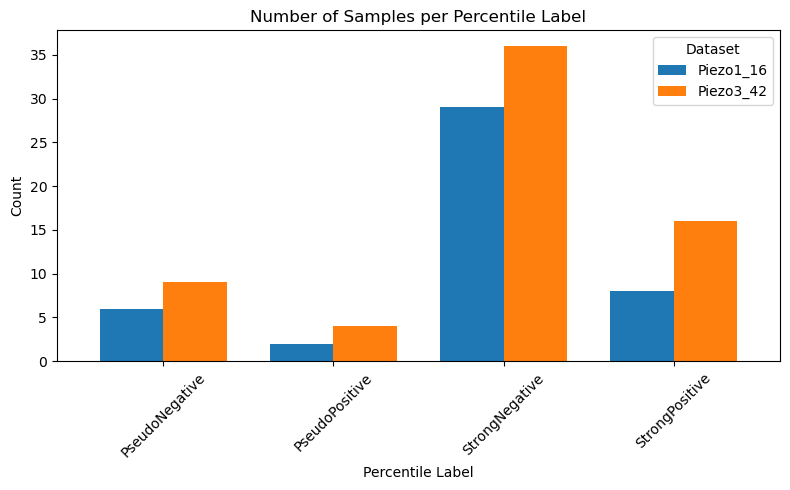

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv("/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GNN/GNN-5A_Exp1/NewResults/TestPiezo1_16CaptureRates.csv")
df2 = pd.read_csv("/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GNN/GNN-5A_Exp1/NewResults/TestPiezo3_42CaptureRates.csv")

# Count labels
counts1 = df1['percentile_label'].value_counts().sort_index()
counts2 = df2['percentile_label'].value_counts().sort_index()

# Combine into a DataFrame
comparison_df = pd.DataFrame({
    'Piezo1_16': counts1,
    'Piezo3_42': counts2
}).fillna(0).astype(int)

# Plot
ax = comparison_df.plot(kind='bar', width=0.75, figsize=(8, 5))
plt.title('Number of Samples per Percentile Label')
plt.xlabel('Percentile Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [10]:
# import glob
# import shutil
# import os

# filenames = glob.glob("/home/alexhernandez/transmembranebindingAI/Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/Test/Positive/*.npy")

# new_pdb_folder = "internal_test"
# os.mkdir(new_pdb_folder)

# for file in filenames:
#     file_base_name = os.path.basename(file)
#     protein_id = file_base_name[:4]

#     source_file = f"/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/GNN/CLR-PDB/{protein_id}_protein.pdb"
#     dest_file = f"{new_pdb_folder}/{protein_id}_protein.pdb"
#     shutil.copy2(source_file, dest_file)
    